In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings('ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input/data-analytics-ue20cs312'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/data-analytics-ue20cs312/sample_submission.csv
/kaggle/input/data-analytics-ue20cs312/train.csv
/kaggle/input/data-analytics-ue20cs312/test.csv


In [2]:
!pip install pmdarima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.8 MB/s eta 0:00:00


In [3]:
data = pd.read_csv('../input/data-analytics-ue20cs312/train.csv')
test_data1 = pd.read_csv("../input/data-analytics-ue20cs312/test.csv")
data.head()


,Date,Open,High,Low,Close,Volume
0,2016-01-04,1099.59,1110.75,1093.85,1109.64,66545000
1,2016-01-05,1117.47,1130.57,1112.75,1125.85,41227200
2,2016-01-06,1116.63,1138.68,1116.10,1133.04,42316800
3,2016-01-07,1122.00,1149.76,1117.56,1143.37,64899600
4,2016-01-08,1145.64,1149.96,1120.93,1122.88,52138900


In [4]:
data['Date']=pd.to_datetime(data['Date'])

In [5]:
test_data1.head()

,Date,Open,High,Low,Volume
0,2022-08-01,2455.71,2500.26,2447.87,24327600
1,2022-08-02,2466.68,2494.73,2447.99,19076300
2,2022-08-03,2473.29,2507.59,2449.39,27459700
3,2022-08-04,2475.98,2487.75,2419.88,23699600
4,2022-08-05,2414.66,2444.17,2409.01,18912400


In [6]:
data.dtypes
test_data1.dtypes

Date       object
Open      float64
High      float64
Low       float64
Volume      int64
dtype: object

In [7]:
data.shape

(1655, 6)

In [8]:
test_data1.shape

(35, 5)

In [9]:
data.describe()
test_data1.describe()

,Open,High,Low,Volume
count,35.000000,35.000000,35.000000,3.500000e+01
mean,2466.907429,2490.780000,2445.025714,2.335596e+07
std,55.799654,55.630929,57.000809,8.760714e+06
min,2359.620000,2394.110000,2343.280000,1.546080e+07
25%,2427.900000,2455.810000,2405.670000,1.869160e+07
50%,2460.990000,2489.170000,2433.030000,2.158430e+07
75%,2494.290000,2514.150000,2471.200000,2.380445e+07
max,2590.500000,2626.420000,2576.820000,6.601140e+07


In [10]:
data.isna().sum()
test_data1.isna().sum()

Date      0
Open      0
High      0
Low       0
Volume    0
dtype: int64

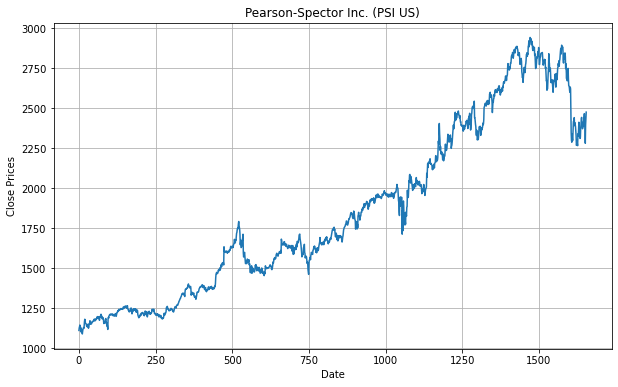

In [11]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(data['Close'])
plt.title('Pearson-Spector Inc. (PSI US)')
plt.show()

<AxesSubplot:ylabel='Density'>

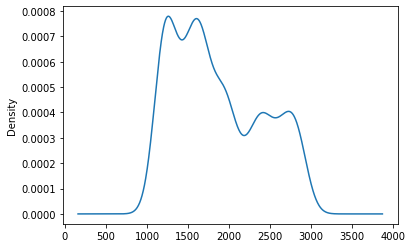

In [12]:
df_close = data['Close']
df_close.plot(kind='kde')

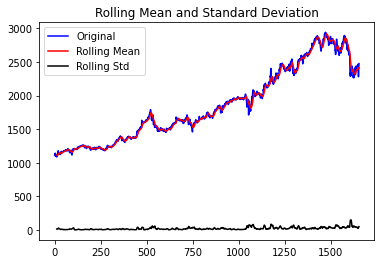

Results of dickey fuller test
Test Statistics                  -0.961490
p-value                           0.767050
No. of lags used                  9.000000
Number of observations used    1645.000000
critical value (1%)              -3.434331
critical value (5%)              -2.863299
critical value (10%)             -2.567706
dtype: float64


In [13]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 432x288 with 0 Axes>

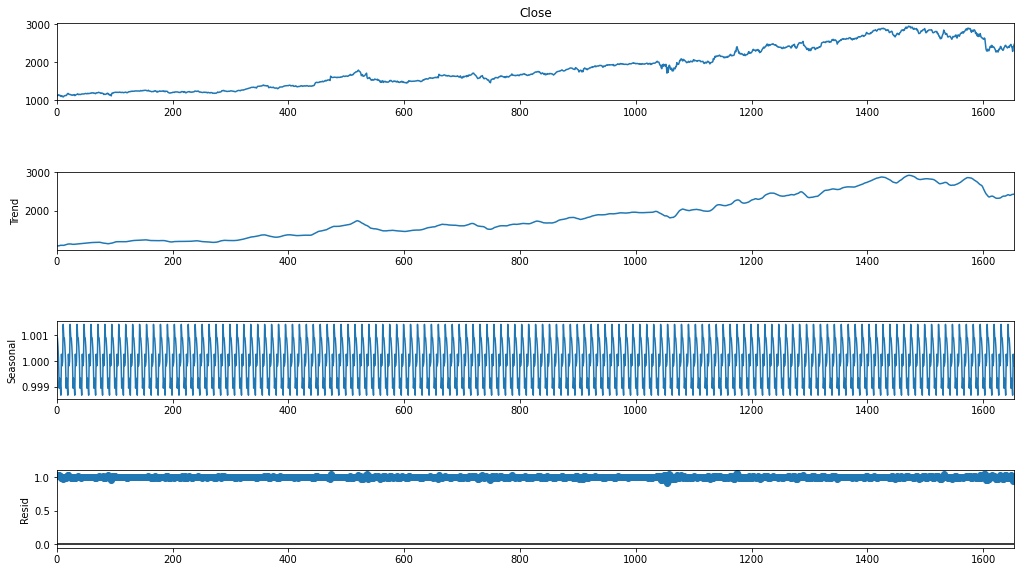

In [14]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', extrapolate_trend='freq', period=12)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

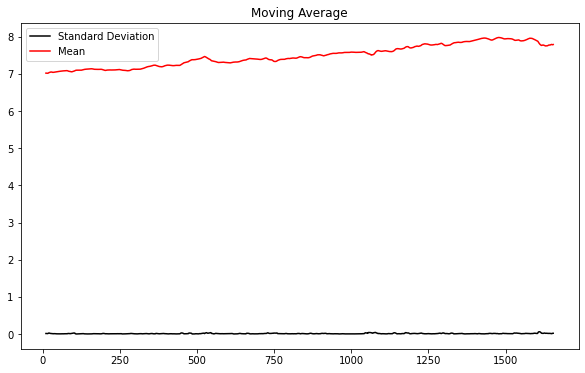

In [15]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [16]:
df_Train=data.iloc[:,:]
df_Test=test_data1.iloc[:,1:]
df_Test

,Open,High,Low,Volume
0,2455.71,2500.26,2447.87,24327600
1,2466.68,2494.73,2447.99,19076300
2,2473.29,2507.59,2449.39,27459700
3,2475.98,2487.75,2419.88,23699600
4,2414.66,2444.17,2409.01,18912400
5,2444.97,2475.18,2433.03,18104900
6,2446.62,2458.88,2427.54,16715500
7,2481.04,2501.79,2463.66,22158000
8,2500.23,2508.87,2467.32,18470800
9,2494.85,2535.06,2486.40,18402700


In [17]:
#split data into train and training set
train_data, test_data = data[0:int(len(data)*0.7)], data[int(len(data)* 0.7):]

In [18]:
test_data

,Date,Open,High,Low,Close,Volume
1158,2020-08-10,2129.29,2158.27,2117.85,2150.37,26451200
1159,2020-08-11,2157.05,2165.96,2120.24,2126.25,30291500
1160,2020-08-12,2131.07,2159.73,2115.47,2153.99,29436400
1161,2020-08-13,2147.67,2165.05,2141.51,2157.45,29848000
1162,2020-08-14,2161.97,2171.08,2149.79,2162.25,27912600
...,...,...,...,...,...,...
1650,2022-07-25,2412.25,2429.44,2387.41,2402.95,29106300
1651,2022-07-26,2289.29,2307.08,2255.66,2280.27,48503400
1652,2022-07-27,2309.14,2404.25,2296.82,2395.54,43790900
1653,2022-07-28,2385.58,2443.26,2377.34,2434.89,25807000


In [19]:
int(len(data))*0.694

1148.57

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10026.957, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9971.963, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9975.109, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10027.604, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9973.896, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9973.901, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9975.960, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=9974.057, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.787 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1158
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -4982.982
Date:                Mon, 18 Dec 2023   AIC                           9971.963
Time:                        05:07

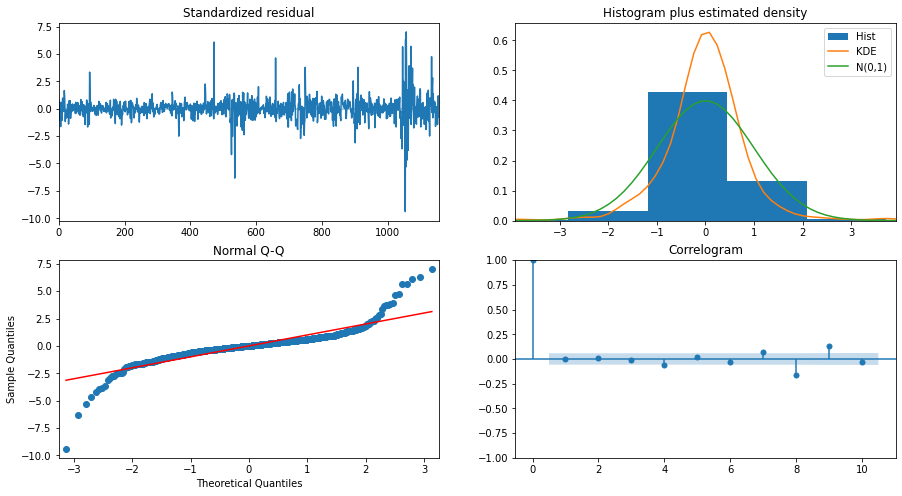

In [20]:
model_autoARIMA = auto_arima(train_data['Close'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [21]:
import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(train_data['Close'], order=(1,1,0))
arima = model.fit()
arima.summary
result = arima.forecast(497, alpha =0.05 )
result

1158    2127.687788
1159    2127.915597
1160    2127.866275
1161    2127.876954
1162    2127.874642
           ...     
1650    2127.875053
1651    2127.875053
1652    2127.875053
1653    2127.875053
1654    2127.875053
Name: predicted_mean, Length: 497, dtype: float64

In [22]:
m1 = arima
print(m1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1158
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -4985.028
Date:                Mon, 18 Dec 2023   AIC                           9974.057
Time:                        05:07:13   BIC                           9984.164
Sample:                             0   HQIC                          9977.871
                               - 1158                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2165      0.009    -23.171      0.000      -0.235      -0.198
sigma2       323.5752      4.465     72.462      0.000     314.823     332.327
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [23]:
forecast_data=pd.read_csv("../input/data-analytics-ue20cs312/train.csv")
forecast_data['Date']=pd.to_datetime(forecast_data['Date'])
forecast_data.rename(columns={'Date':'ds'},inplace=True)


In [24]:
# result1=result[:35]
# result1

In [25]:
# result.to_csv("submission.csv",index=False,)

In [26]:
submission =test_data1[["Date"]]
submission

,Date
0,2022-08-01
1,2022-08-02
2,2022-08-03
3,2022-08-04
4,2022-08-05
5,2022-08-08
6,2022-08-09
7,2022-08-10
8,2022-08-11
9,2022-08-12


In [27]:
submission["Close"] = result

In [28]:
submission = submission[:35]
submission

,Date,Close
0,2022-08-01,NaN
1,2022-08-02,NaN
2,2022-08-03,NaN
3,2022-08-04,NaN
4,2022-08-05,NaN
5,2022-08-08,NaN
6,2022-08-09,NaN
7,2022-08-10,NaN
8,2022-08-11,NaN
9,2022-08-12,NaN


In [29]:
submission.to_csv('submission.csv',index=None)